# CC Sales Forecasting

**Objective:** Adjust Morgan Stanley's estimates of Safeway monthly sales (sourced from data vendors) using actual CC sales provided by Safeway.

The purpose of this notebook is to illustrate how two companies might use Cape to collaboratively train a linear regression model.

In [109]:
import os
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from cape.api.dataview import DataView
from cape.api.job import VerticalLinearRegressionJob
from cape.cape import Cape

In [2]:
path = Path('data')

# 1. Authenticate with the Cape system

In [3]:
CAPE_TOKEN = os.environ.get("CAPE_TOKEN") or "01EXJG1ZTS67BVKSKS8JGPE45H,AceQToHjMLGZDKDDrBte-a3Y4Y_BsgcPKw"
CAPE_PROJECT = os.environ.get("CAPE_PROJECT") or "01EXJECC3M5F4QE52PRVF608FD"
CAPE_COORDINATOR = os.environ.get("CAPE_COORDINATOR") or "https://demo.capeprivacy.com"

First, we login to the Cape service via a Python client. This token was generated from the UX, and is unique to the user and organization they're registered with.

In [4]:
c = Cape(endpoint=CAPE_COORDINATOR)
c.login(token=CAPE_TOKEN)

cape endpoint https://demo.capeprivacy.com
token 01EXJG1ZTS67BVKSKS8JGPE45H,AceQToHjMLGZDKDDrBte-a3Y4Y_BsgcPKw


We can look through the projects that I've been assigned as a contributor for. We'll use the `sales-projections` project, which is linked to the Morgan Stanley (`ms`) and Safeway (`sw`) orgs in Cape.

In [5]:
c.list_projects()

PROJECT ID                  NAME            LABEL
--------------------------  --------------  ----------------
01EXJE9N2HSY9KN1T9T52KWQRG  demo            sales-projection
01EXJECC3M5F4QE52PRVF608FD  sales-forecast  sales-forecast

In [6]:
project = c.get_project("01EXJECC3M5F4QE52PRVF608FD")

## 1. Data Preparation
### a. Morgan Stanley Data

Morgan Stanley's investment arm buys credit card panels from data vendors who work with with financial institutions directly to collect the data. Here are some variables we can expect to find in a credit card panel for one of the portfolio company.
- transaction id
- transaction date
- transaction amount
- merchant description
- mcc
- brand name
- merchant location (address, city, state, state, zip, lat, lon)
- symbol
- card type
- card location (zip, cbsa)
- individual demographics (income, age)

Because the objective is to adjust the dataset at aggregate level (amount by day and state) and not the individual transactions, we created a mock dataset just including the fields: transaction_date, state and ms_transaction_amount.

In [29]:
ms_data = pd.read_csv(path / 'ms' / 'ms_data.csv')
ms_data.head()

,transaction_date,state,ms_transaction_amount
0,2020-01-01,CA,7
1,2020-01-02,CA,7
2,2020-01-03,CA,11
3,2020-01-04,CA,6
4,2020-01-05,CA,8


Because we want to adjust the estimated sales by day/state, we aggregate `ms_transaction_amount` transactions by day/state.

In [30]:
ms_agg = ms_data.groupby(["transaction_date", "state"]).agg({"ms_transaction_amount": "sum"}).rename(columns={"ms_transaction_amount": "ms_total_estimated_sales"})
ms_agg.head()

ms_total_estimated_sales
transaction_date state                          
2020-01-01       CA                           87
                 NY                           94
2020-01-02       CA                           95
                 NY                          100
2020-01-03       CA                           99

Finally, the data owner from Morgan Stanley can create a dataview pointing to the location where this dataset will be stored. In this case, it's in an S3 bucket.

In [14]:
for org in project.organizations:
    print(org)

<Organization (id=01EXJE8HYAQJN7XS627VRWSRC0, name=safeway-tech-2)>
<Organization (id=01EXJE7XNSRFKRSXX9FZ2XVCE7, name=morgan-stanley-2)>


In [141]:
ms_dataview = DataView(
    name="morgan-stanley-agg-data",
    owner_id=project.organizations[1].id,
    uri='x_data',
    schema=ms_agg.dtypes
)
project.add_dataview(ms_dataview)

DataView(id=01EXJYSVZ4XSETSE90JBN99K06, name=morgan-stanley-agg-data, location=None)

## b. Safeway data

Safeway has access to their actual sales transaction. We can expect the following fields in the dataset:

- transaction id
- transaction date
- location (Safeway only need detail at state level)
- transaction type (credit/debit, cash, etc.)
- transaction amount

For the same reason before, we created a mock dataset just including the fields: transaction_date, state and sw_transaction_amount.

In [64]:
sw_data = pd.read_csv(path / 'sw' / 'sw_data.csv')
sw_data.head()

,transaction_date,state,sw_transaction_amount
0,2020-01-01,CA,15
1,2020-01-02,CA,16
2,2020-01-03,CA,23
3,2020-01-04,CA,14
4,2020-01-05,CA,18


In [65]:
sw_agg = sw_data.groupby(["transaction_date", "state"]).agg({"sw_transaction_amount": "sum"}).rename(columns={"sw_transaction_amount": "sw_total_estimated_sales"})
sw_agg.head()

sw_total_estimated_sales
transaction_date state                          
2020-01-01       CA                          188
                 NY                          204
2020-01-02       CA                          204
                 NY                          216
2020-01-03       CA                          213

In [60]:
for org in project.organizations:
    print(org)

<Organization (id=01EXJE8HYAQJN7XS627VRWSRC0, name=safeway-tech-2)>
<Organization (id=01EXJE7XNSRFKRSXX9FZ2XVCE7, name=morgan-stanley-2)>


In [142]:
sw_dataview = DataView(
    name="safeway-agg-data",
    owner_id=project.organizations[0].id,
    uri='y_data',
    schema=sw_agg.dtypes
)
project.add_dataview(sw_dataview)


DataView(id=01EXJYTASXAACWPCZ5CR5BTRYV, name=safeway-agg-data, location=None)

# Morgan Stanley -- Linear Regression Job

### a. Training

Now the data scientist can inspect the project and its available dataviews on their end.

In [148]:
dataviews = project.list_dataviews()
dataviews

DATAVIEW ID                 NAME                     LOCATION    SCHEMA
--------------------------  -----------------------  ----------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------
01EXJYSVZ4XSETSE90JBN99K06  morgan-stanley-agg-data              {'level_0': 'integer', 'index': 'integer', 'transaction_date': 'datetime', 'state': 'string', 'ms_total_estimated_sales': 'integer', 'predicted_sales': 'number'}
01EXJYTASXAACWPCZ5CR5BTRYV  safeway-agg-data                     {'transaction_date': 'datetime', 'state': 'string', 'sw_total_estimated_sales': 'integer'}

In [149]:
morgan_stanley_dataview = project.get_dataview("01EXJYSVZ4XSETSE90JBN99K06")
safeway_dataview = project.get_dataview("01EXJYTASXAACWPCZ5CR5BTRYV")

Finally, we can use these dataviews to create a linear regression training job. Since the input variables and output variables are split across different dataviews, we specify this as a `VerticalLinearRegressionJob`. These dataviews are references to datasets that live elsewhere, so we just need to specify which columns in the dataview we want to use for the input and output variables of the model.

In [166]:
job = VerticalLinearRegressionJob(
        x_train_dataview=morgan_stanley_dataview,
        x_train_data_cols=['ms_total_estimated_sales'],
        y_train_dataview=safeway_dataview,
        y_train_data_cols=['sw_total_estimated_sales'],
    )

We can submit the job for execution. It should now be visible in the Cape UI. Under the hood, this sets up a worker Session on the Cape Coordinator, which will be used to orchestrate and compute the encrypted linear regression.

In [167]:

job = project.submit_job(job=job)

job

VerticalLinearRegressionJob(id=01EXK6HK1SB30GDM0JKE5SY2AH, job_type=LINEAR_REGRESSION, status=Initialized)

### b. Results

We can check the status of this job here, and when it's complete we can fetch the results.


In [168]:
job.get_status()

'Completed'

In [169]:
weights, metrics = job.get_results()

#### i. Accuracy before training

In [170]:
print("Before Training:\n")
rmse_pre_training = np.sqrt(mean_squared_error(sw_agg["sw_total_estimated_sales"].values, ms_agg["ms_total_estimated_sales"].values))
print(f"Root-Mean-Squared error: {round(rmse_pre_training, 3)}")

Before Training:

Root-Mean-Squared error: 110.005


#### ii. Accuracy after training:

In [171]:
print("After Training:\n")
print(f"Model weights: {weights}")
print(f"R-Squared: {np.round(metrics['r_squared_result'], 4)}")
print(f"Root Mean-Squared Error: {np.round(np.sqrt(metrics['mse_result']), 3)}")

After Training:

Model weights: [12.13157093  2.02873725]
R-Squared: 0.9933
Root Mean-Squared Error: 1.463


#### iii. Predict sales using the trained linear regression 

In [156]:
def inference(x, weights):
    b, w = weights
    y_hat = np.dot(x, w) + b
    return y_hat

In [159]:
prediction = inference(ms_agg["ms_total_estimated_sales"], weights)
ms_agg['predicted_sales'] = prediction

ms_agg.head()

,level_0,index,transaction_date,state,ms_total_estimated_sales,predicted_sales
0,0,0,2020-01-01,CA,87,188.631712
1,1,1,2020-01-01,NY,94,202.832872
2,2,2,2020-01-02,CA,95,204.861610
3,3,3,2020-01-02,NY,100,215.005296
4,4,4,2020-01-03,CA,99,212.976559


### iiii. Prediction vs Morgan Stanley Estimaed Sales vs Safeway Actual Sales

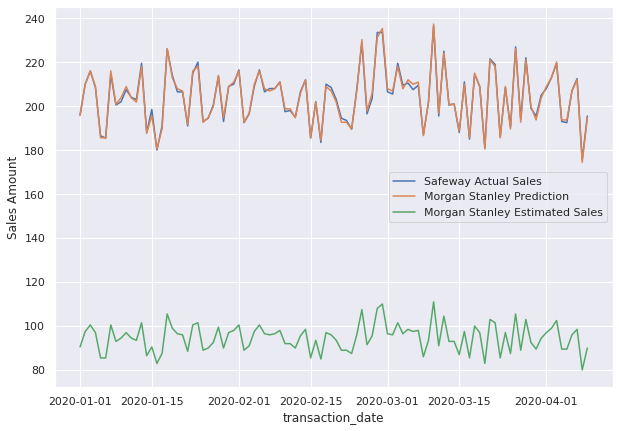

In [161]:
ms_agg = ms_agg.reset_index()
ms_agg['transaction_date']= pd.to_datetime(ms_agg['transaction_date'])

sw_agg = sw_agg.reset_index()
sw_agg['transaction_date']= pd.to_datetime(sw_agg['transaction_date'])

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10, 7)})
sns.lineplot(x="transaction_date", y="sw_total_estimated_sales", data=sw_agg, ci=None, label="Safeway Actual Sales")
sns.lineplot(x="transaction_date", y="predicted_sales", data=ms_agg, ci=None, label="Morgan Stanley Prediction")
sns.lineplot(x="transaction_date", y="ms_total_estimated_sales", data=ms_agg, ci=None, label="Morgan Stanley Estimated Sales")
plt.ylabel("Sales Amount")
plt.show()
